📌 참고한 자료: https://www.kaggle.com/code/gpiosenka/animal-faces-f1-test-score-99-7

### 필요한 라이브러리 호출

In [ ]:
# 코랩에서 구글 드라이브 접근
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import pandas as pd
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import time
import albumentations as A
from tqdm import tqdm
from sklearn.metrics import f1_score
from IPython.display import YouTubeVideo
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

### dataframe 개수 plot 그리는 함수 정의

In [ ]:
def plot_label_count (df, plot_title):
    column='labels'
    xaxis_label='CLASS'
    yaxis_label='IMAGE COUNT'
    vcounts=df[column].value_counts()
    labels=vcounts.keys().tolist()
    values=vcounts.tolist()
    lcount=len(labels)
    if lcount>55:
        print('The number of labels is >55, no plot will be produced')
    else:
        width=lcount * 4
        width=np.min([width, 20])
        plt.figure(figsize=(width,5))
        form = {'color': 'pink', 'size': 25}
        plt.bar(labels, values)
        plt.title(plot_title, fontsize= 24, color='pink')
        plt.xticks(rotation=90, fontsize=18)
        plt.yticks(fontsize=18)
        plt.xlabel(xaxis_label, fontdict=form)
        plt.ylabel(yaxis_label, fontdict=form)
        if lcount >=8:
            rotation='vertical'
        else:
            rotation='horizontal'
        for i in range(lcount):
            plt.text(i, values[i]/2, str(values[i]),fontsize=12, rotation=rotation, color='purple', ha='center')
        plt.show()

### 데이터 불러오기 - 🔥 (new_train.csv에는 Multi-label 포함X, train.csv에는 Multi-label 포함O)

* 현재 코드는 multi-label 포함하지 않은 데이터셋에 대해여 학습 시킴.

In [ ]:
imgdir=r'/content/drive/MyDrive/졸업과제/severstal-steel-defect-detection/train_images'
df=pd.read_csv(r'/content/drive/MyDrive/졸업과제/severstal-steel-defect-detection/new_train.csv')
df=df.drop('EncodedPixels', axis=1)
df.columns=['filepaths', 'labels']
df['filepaths']=df['filepaths'].apply(lambda x: os.path.join(imgdir,x))
df['labels'] =df['labels'].apply(lambda x: str(x))
print(df.head())

                                                                                 filepaths  \
0  /content/drive/MyDrive/졸업과제/severstal-steel-defect-detection/train_images/0002cc93b.jpg   
1  /content/drive/MyDrive/졸업과제/severstal-steel-defect-detection/train_images/0007a71bf.jpg   
2  /content/drive/MyDrive/졸업과제/severstal-steel-defect-detection/train_images/000a4bcdd.jpg   
3  /content/drive/MyDrive/졸업과제/severstal-steel-defect-detection/train_images/000f6bf48.jpg   
4  /content/drive/MyDrive/졸업과제/severstal-steel-defect-detection/train_images/0014fce06.jpg   

  labels  
0      1  
1      3  
2      1  
3      4  
4      3  


💖 8:1:1 비율로 데이터셋 나누기

In [ ]:
def split_df(df, trsize, column):
    train_df, dummy_df = train_test_split(df, train_size=trsize, shuffle=True, random_state=123, stratify=df[column])
    valid_df, test_df= train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=123, stratify=dummy_df[column])
    print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))
    return train_df, test_df, valid_df

train_df, test_df, valid_df  = split_df(df, .8, 'labels')

train_df length:  4991   test_df length:  624   valid_df length:  624


3    3807
1     615
4     413
2     156
Name: labels, dtype: int64


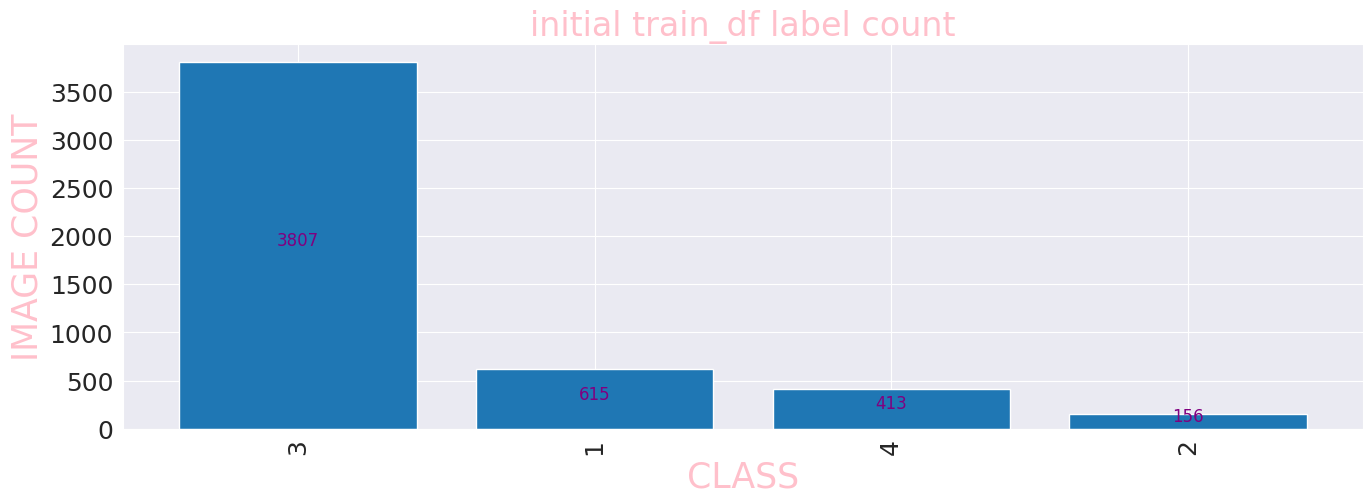

In [ ]:
count=train_df['labels'].value_counts()
print (count)
plot_title='initial train_df label count'
plot_label_count (train_df, plot_title)

### train, test, valid

In [ ]:
def make_gens(batch_size, ycol, train_df, test_df, valid_df, img_size):
    trgen=ImageDataGenerator(horizontal_flip=True)
    t_and_v_gen=ImageDataGenerator()
    msg='{0:70s} for train generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col=ycol, target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
    msg='{0:70s} for valid generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col=ycol, target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
    # for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
    # this insures that we go through all the sample in the test set exactly once.
    length=len(test_df)
    test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
    test_steps=int(length/test_batch_size)
    msg='{0:70s} for test generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col=ycol, target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
    # from the generator we can get information we will need later
    classes=list(train_gen.class_indices.keys())
    class_indices=list(train_gen.class_indices.values())
    class_count=len(classes)
    labels=test_gen.labels
    print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)
    return train_gen, test_gen, valid_gen, test_steps

bs=30
ycol='labels'
train_gen, test_gen, valid_gen, test_steps = make_gens(bs, ycol, train_df, test_df, valid_df, img_size)


Found 4991 validated image filenames belonging to 4 classes.
Found 624 validated image filenames belonging to 4 classes.
Found 624 validated image filenames belonging to 4 classes.
test batch size:  78   test steps:  8  number of classes :  4


### fl score 산출 함수

In [10]:
def F1_score(y_true, y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    _y_true = K.sum(K.round(K.clip(y_true, 0, 1)))
    _y_pred = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = tp / (_y_pred + K.epsilon())
    recall = tp / (_y_true + K.epsilon())
    f1_score = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_score

### EfficientNet 모델 정의


In [3]:
class_count = 4

In [5]:
img_size = (100,625)

In [6]:
def make_model(img_size, lr, mod_num=3):
    img_shape=(img_size[0], img_size[1], 3)
    if mod_num == 0:
        base_model=tf.keras.applications.efficientnet.EfficientNetB0(
            include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')

    elif mod_num == 3:
        base_model=tf.keras.applications.efficientnet.EfficientNetB3(
            include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')


    base_model.trainable=True
    x=base_model.output
    x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
    x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                    bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
    x=Dropout(rate=.4, seed=123)(x)
    output=Dense(class_count, activation='softmax')(x)
    model=Model(inputs=base_model.input, outputs=output)
    model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy', F1_score, 'AUC'])

    return model

### 학습 결과 plot 함수

In [ ]:
def tr_plot(tr_data):
    start_epoch=0
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    tf1=tr_data.history['F1_score']
    vf1=tr_data.history['val_F1_score']
    tauc=tr_data.history['auc']
    vauc=tr_data.history['val_auc']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    auc_index=np.argmax(vauc)
    val_highest_auc=vauc[auc_index]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    auc_label='best epoch= ' + str(auc_index + 1 + start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=4, figsize=(25,10))
    axes[0].plot(Epochs,tloss, 'c', label='Training loss')
    axes[0].plot(Epochs,vloss,'m',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=100, c= 'blue', label=sc_label)
    axes[0].scatter(Epochs, tloss, s=50, c='c')
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=18)
    axes[0].set_ylabel('Loss', fontsize=18)
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'c',label= 'Training Accuracy')
    axes[1].scatter(Epochs, tacc, s=50, c='c')
    axes[1].plot (Epochs,vacc,'m',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=100, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=18)
    axes[1].set_ylabel('Accuracy', fontsize=18)
    axes[1].legend()
    axes[2].plot (Epochs,tf1,'c',label= 'Training F1 score')
    axes[2].plot (Epochs,vf1,'m',label= 'Validation F1 score')
    index_tf1=np.argmax(tf1)#  this is the epoch with the highest training F1 score
    tf1max=tf1[index_tf1]
    index_vf1=np.argmax(vf1)# thisiis the epoch with the highest validation F1 score
    vf1max=vf1[index_vf1]
    axes[2].scatter(index_vf1+1 +start_epoch,vf1max, s=150, c= 'blue', label=vc_label)
    axes[2].scatter(Epochs, tf1, s=50, c='c')
    axes[2].set_title('Training and Validation F1 score')
    axes[2].set_xlabel('Epochs', fontsize=18)
    axes[2].set_ylabel('F1  score', fontsize=18)
    axes[2].legend()
    axes[3].plot(Epochs,tauc, 'c', label='Training AUC')
    axes[3].plot(Epochs,vauc,'m',label='Validation AUC' )
    axes[3].scatter(auc_index+1 +start_epoch,val_highest_auc, s=100, c= 'blue', label=sc_label)
    axes[3].scatter(Epochs, tauc, s=50, c='c')
    axes[3].set_title('Training and Validation AUC')
    axes[3].set_xlabel('Epochs', fontsize=18)
    axes[3].set_ylabel('AUC', fontsize=18)
    axes[3].legend()
    plt.tight_layout
    plt.show()
    return

### EfficientNet B0 모델 학습

In [11]:
lr=.001
model=make_model(img_size, lr, 0) # using B0 model by default
epochs=100
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  # validation accuracy를 모니터링
    patience=60,               # 몇 번의 에폭 동안 향상이 없으면 조기 중지할지 설정
    min_delta=0.001,
    restore_best_weights=True
)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    '/content/drive/MyDrive/졸업과제/모델/EfficientNet/B0.h5',  # 모델을 저장할 파일 이름
    monitor='val_accuracy',
    save_best_only=True,  # 가장 좋은 모델만 저장
    mode='max',  # 'max'면 모니터링 지표가 최대값일 때 저장, 'min'이면 최소값일 때 저장
    verbose=1
)

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
callbacks = [early_stopping, model_checkpoint]

# 모델 훈련 시 콜백을 적용
history = model.fit(
    x=train_gen,
    epochs=epochs,
    verbose=1,
    callbacks=callbacks,
    validation_data=valid_gen,
    validation_steps=None,
    shuffle=False,
    initial_epoch=0
)

Epoch 1/100
167/167 [==============================] - ETA: 0s - loss: 6.2619 - accuracy: 0.8305 - F1_score: 0.8300 - auc: 0.9557 
Epoch 1: val_accuracy improved from -inf to 0.87981, saving model to /content/drive/MyDrive/졸업과제/모델/EfficientNet/B0.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


167/167 [==============================] - 2744s 16s/step - loss: 6.2619 - accuracy: 0.8305 - F1_score: 0.8300 - auc: 0.9557 - val_loss: 4.7586 - val_accuracy: 0.8798 - val_F1_score: 0.8758 - val_auc: 0.9776
Epoch 2/100
167/167 [==============================] - ETA: 0s - loss: 3.6799 - accuracy: 0.9189 - F1_score: 0.9197 - auc: 0.9891
Epoch 2: val_accuracy improved from 0.87981 to 0.91346, saving model to /content/drive/MyDrive/졸업과제/모델/EfficientNet/B0.h5
167/167 [==============================] - 62s 370ms/step - loss: 3.6799 - accuracy: 0.9189 - F1_score: 0.9197 - auc: 0.9891 - val_loss: 2.9509 - val_accuracy: 0.9135 - val_F1_score: 0.9177 - val_auc: 0.9902
Epoch 3/100
167/167 [==============================] - ETA: 0s - loss: 2.3954 - accuracy: 0.9409 - F1_score: 0.9391 - auc: 0.9928
Epoch 3: val_accuracy improved from 0.91346 to 0.94231, saving model to /content/drive/MyDrive/졸업과제/모델/EfficientNet/B0.h5
167/167 [==============================] - 63s 377ms/step - loss: 2.3954 - accur

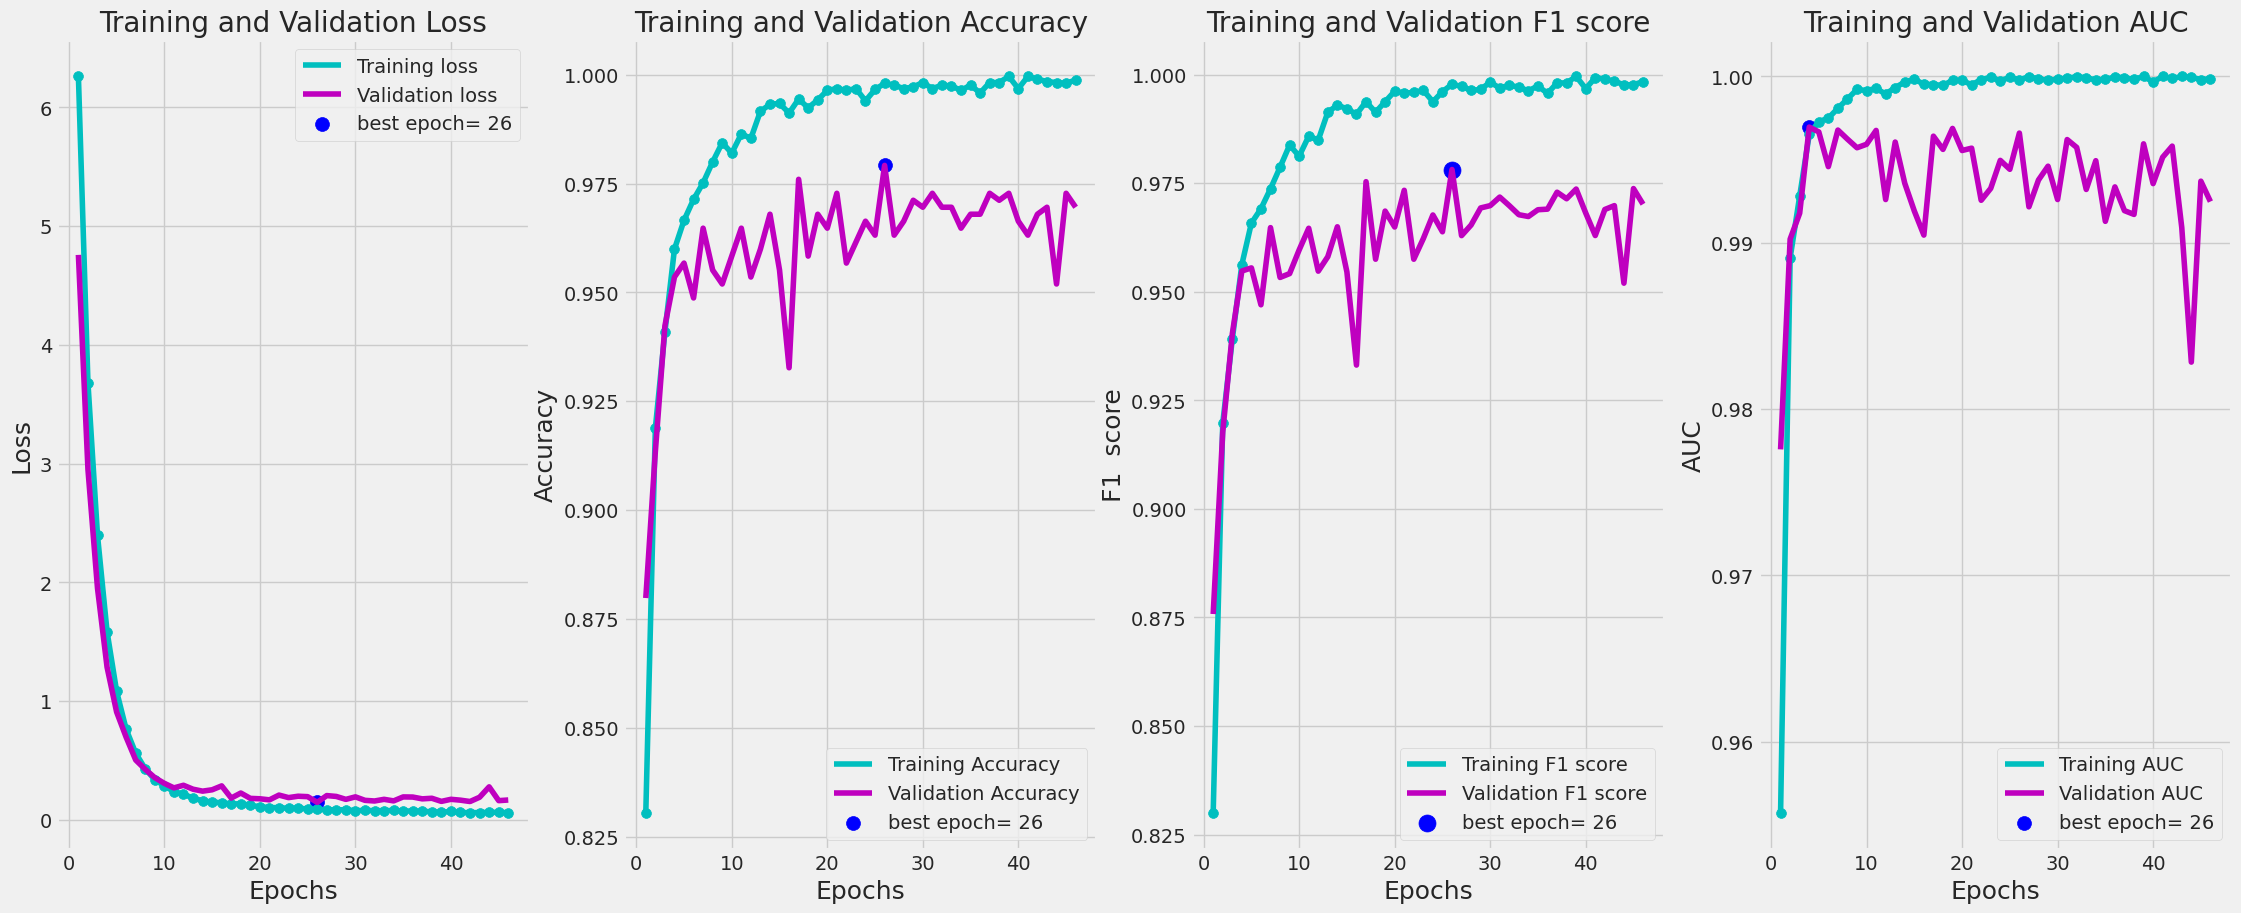

In [ ]:
tr_plot(history)

In [ ]:
from tensorflow.keras.models import load_model

# 저장된 모델을 로드
loaded_model = load_model('/content/drive/MyDrive/졸업과제/모델/EfficientNet/B0.h5',custom_objects={'F1_score': F1_score})

In [ ]:
from tensorflow.keras.models import load_model
# 저장된 모델을 로드
loaded_model = load_model('/content/drive/MyDrive/졸업과제/모델/EfficientNet/B0.h5',custom_objects={'F1_score': F1_score})
loaded_model.evaluate(
    x=test_gen,
    verbose=1
)

8/8 [==============================] - 7s 500ms/step - loss: 0.2024 - accuracy: 0.9744 - F1_score: 0.9735 - auc: 0.9904


[0.20244283974170685,
 0.9743589758872986,
 0.9735420942306519,
 0.9903632402420044]

In [ ]:
test_results = loaded_model.evaluate(
    x=test_gen,
    verbose=1
)

8/8 [==============================] - 6s 371ms/step - loss: 0.1911 - accuracy: 0.9647 - F1_score: 0.9655 - auc: 0.9947


In [ ]:
test_results = model.evaluate(
    x=test_gen,
    verbose=1
)

8/8 [==============================] - 4s 308ms/step - loss: 0.7049 - accuracy: 0.9647 - F1_score: 0.9654 - auc: 0.9975


### EfficientNet B3 모델 학습

In [9]:
lr=.001
model=make_model(img_size, lr, 3) # using B3 model by default
epochs=100
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  # validation accuracy를 모니터링
    patience=40,               # 몇 번의 에폭 동안 향상이 없으면 조기 중지할지 설정
    min_delta=0.001,
    restore_best_weights=True
)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    '/content/drive/MyDrive/졸업과제/모델/EfficientNet/B0.h5',  # 모델을 저장할 파일 이름
    monitor='val_accuracy',
    save_best_only=True,  # 가장 좋은 모델만 저장
    mode='max',  # 'max'면 모니터링 지표가 최대값일 때 저장, 'min'이면 최소값일 때 저장
    verbose=1
)

In [ ]:
callbacks = [early_stopping, model_checkpoint]

# 모델 훈련 시 콜백을 적용
history = model.fit(
    x=train_gen,
    epochs=epochs,
    verbose=1,
    callbacks=callbacks,
    validation_data=valid_gen,
    validation_steps=None,
    shuffle=False,
    initial_epoch=0
)

Epoch 1/100
167/167 [==============================] - ETA: 0s - loss: 6.7576 - accuracy: 0.8119 - F1_score: 0.8076 - auc: 0.9461
Epoch 1: val_accuracy improved from -inf to 0.91987, saving model to /content/drive/MyDrive/졸업과제/모델/EfficientNet/B0.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


167/167 [==============================] - 1824s 11s/step - loss: 6.7576 - accuracy: 0.8119 - F1_score: 0.8076 - auc: 0.9461 - val_loss: 5.1862 - val_accuracy: 0.9199 - val_F1_score: 0.9188 - val_auc: 0.9872
Epoch 2/100
167/167 [==============================] - ETA: 0s - loss: 4.1965 - accuracy: 0.9219 - F1_score: 0.9200 - auc: 0.9876
Epoch 2: val_accuracy improved from 0.91987 to 0.95353, saving model to /content/drive/MyDrive/졸업과제/모델/EfficientNet/B0.h5
167/167 [==============================] - 116s 694ms/step - loss: 4.1965 - accuracy: 0.9219 - F1_score: 0.9200 - auc: 0.9876 - val_loss: 3.3992 - val_accuracy: 0.9535 - val_F1_score: 0.9532 - val_auc: 0.9941
Epoch 3/100
167/167 [==============================] - ETA: 0s - loss: 2.8309 - accuracy: 0.9531 - F1_score: 0.9479 - auc: 0.9943
Epoch 3: val_accuracy improved from 0.95353 to 0.96314, saving model to /content/drive/MyDrive/졸업과제/모델/EfficientNet/B0.h5
167/167 [==============================] - 115s 685ms/step - loss: 2.8309 - acc

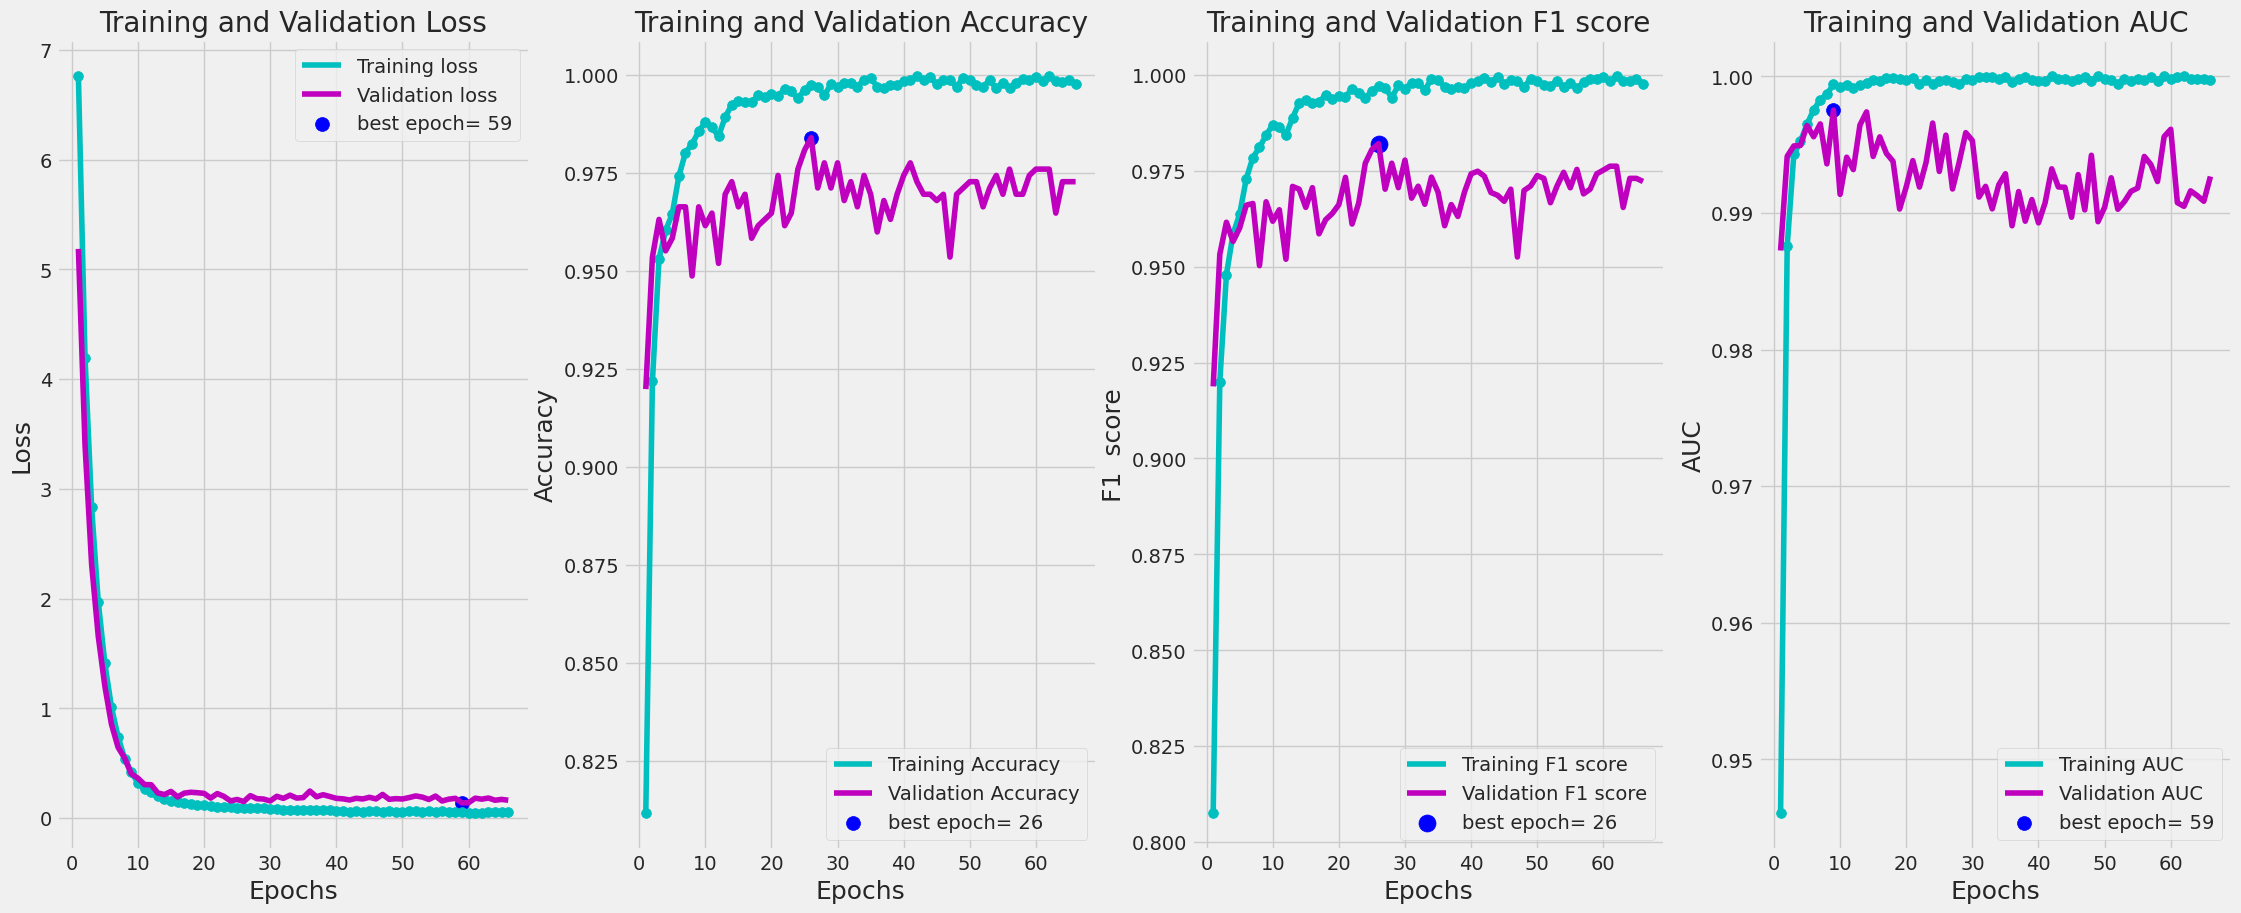

In [ ]:
tr_plot(history)

In [ ]:
test_results = model.evaluate(
    x=test_gen,
    verbose=1
)

8/8 [==============================] - 176s 25s/step - loss: 0.2024 - accuracy: 0.9744 - F1_score: 0.9735 - auc: 0.9904


### 저장된 B3 모델 로드하여 성능 평가하기

In [ ]:
from tensorflow.keras.models import load_model

# 저장된 모델을 로드
loaded_model = load_model('/content/drive/MyDrive/졸업과제/모델/EfficientNet/B3-100epoch.h5',custom_objects={'F1_score': F1_score})

In [ ]:
test_images, test_labels = next(test_gen)
predictions = loaded_model.predict(test_images)

3/3 [==============================] - 26s 6s/step


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

class_ids = [1, 2, 3, 4]
for class_id in class_ids:
    class_predictions = predictions[:, class_id-1]  # 해당 클래스에 대한 예측값 추출 (인덱스는 0부터 시작하므로 -1)
    class_labels = test_labels[:, class_id-1]  # 해당 클래스에 대한 실제 레이블 추출 (인덱스는 0부터 시작하므로 -1)

    accuracy = accuracy_score(class_labels, np.round(class_predictions))
    f1score = f1_score(class_labels, np.round(class_predictions))
    precision = precision_score(class_labels, np.round(class_predictions))
    recall = recall_score(class_labels, np.round(class_predictions))

    print(f"Class {class_id}: Accuracy={accuracy}, F1-score={f1score}, precision={precision}, recall ={recall}")

Class 1: Accuracy=0.9487179487179487, F1-score=0.6666666666666666, precision=0.5714285714285714, recall =0.8
Class 2: Accuracy=0.9743589743589743, F1-score=0.6666666666666666, precision=0.6666666666666666, recall =0.6666666666666666
Class 3: Accuracy=0.9615384615384616, F1-score=0.9763779527559054, precision=1.0, recall =0.9538461538461539
Class 4: Accuracy=0.9871794871794872, F1-score=0.9090909090909091, precision=0.8333333333333334, recall =1.0


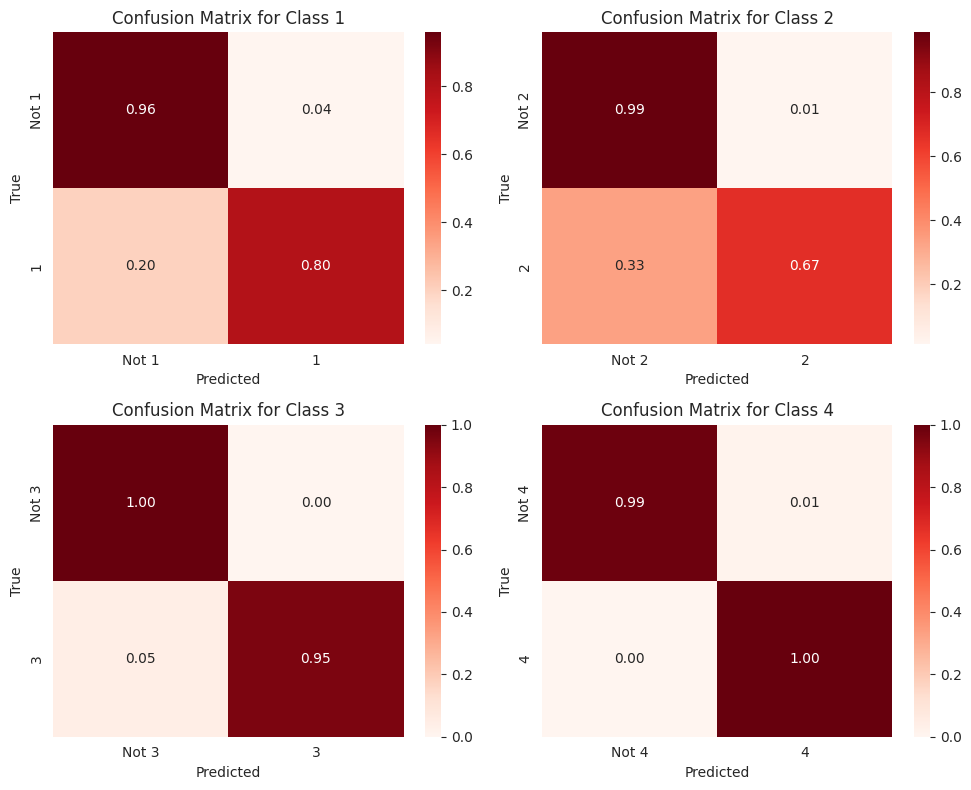

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

class_ids = [1, 2, 3, 4]
confusion_matrices = []

for class_id in class_ids:
    class_predictions = predictions[:, class_id-1]  # 해당 클래스에 대한 예측값 추출 (인덱스는 0부터 시작하므로 -1)
    class_labels = test_labels[:, class_id-1]  # 해당 클래스에 대한 실제 레이블 추출 (인덱스는 0부터 시작하므로 -1)

    cm = confusion_matrix(class_labels, np.round(class_predictions), normalize='true')
    confusion_matrices.append(cm)

# Confusion Matrix 시각화
plt.figure(figsize=(10, 8))
for i in range(len(class_ids)):
    plt.subplot(2, 2, i+1)

    sns.heatmap(confusion_matrices[i], annot=True, fmt='.2f', cmap='Reds',
                xticklabels=['Not '+str(class_ids[i]), str(class_ids[i])],
                yticklabels=['Not '+str(class_ids[i]), str(class_ids[i])])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for Class {class_ids[i]}')

plt.tight_layout()
plt.show()


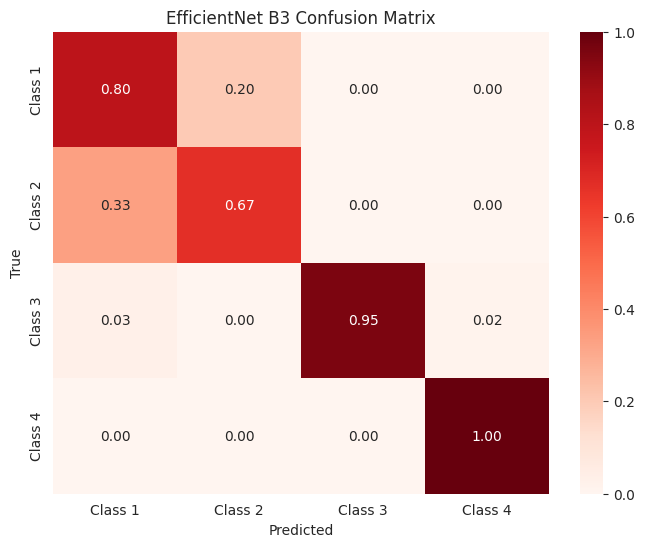

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 예측 결과와 실제 레이블 추출
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)

# 전체 혼동 행렬 계산
cm = confusion_matrix(true_labels, predicted_labels, normalize='true')

# Confusion Matrix 시각화
class_names = ['Class 1', 'Class 2', 'Class 3', 'Class 4']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Reds',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('EfficientNet B3 Confusion Matrix')

plt.show()


In [ ]:
test_results = loaded_model.evaluate(
    x=test_gen,
    verbose=1
)